# Predicting Student Admissions - Business Case Study - Tensorflow 2.0.0
---
Author: Bhaveshkumar Thaker

---

predict student admissions to graduate school at UCLA based on three pieces of data:


*   GRE Scores (Test)
*   GPA Scores (Grades)
*   Class rank (1-4)

In [1]:
root_dir = ''
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-2-projects/'
    
    !pip install tensorflow-gpu
except:
    print('No GOOGLE DRIVE connection. Using local dataset(s).')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 380.8MB 78kB/s 
     |████████████████████████████████| 3.8MB 27.7MB/s 
     |████████████████████████████████| 450kB 40.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: t

## Import Libraries

In [0]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [3]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [4]:
seed = 321

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

plt.figure(figsize = (14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS
sns.set(rc={'figure.figsize' : (14, 11), 'figure.facecolor': 'whitesmoke', 'axes.facecolor': 'whitesmoke', 'grid.color': 'slategrey'})
sns.color_palette(palette = list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Load the Data

In [5]:
uclastudent_dataset = pd.read_csv(root_dir + 'datasets/ucla_student_admission-classification.csv')
uclastudent_dataset.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Data Insights

In [6]:
uclastudent_dataset.shape

(400, 4)

In [7]:
uclastudent_dataset.dtypes

admit      int64
gre        int64
gpa      float64
rank       int64
dtype: object

In [8]:
uclastudent_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
admit,400.0,0.3175,0.466087,0.00,0.00,0.000,1.00,1.0
gre,400.0,587.7000,115.516536,220.00,520.00,580.000,660.00,800.0
gpa,400.0,3.3899,0.380567,2.26,3.13,3.395,3.67,4.0
rank,400.0,2.4850,0.944460,1.00,2.00,2.000,3.00,4.0


In [9]:
uclastudent_dataset.nunique()

admit      2
gre       26
gpa      132
rank       4
dtype: int64

In [10]:
uclastudent_dataset.isnull().sum(axis=0)

admit    0
gre      0
gpa      0
rank     0
dtype: int64

In [11]:
label, count = np.unique(uclastudent_dataset['admit'], return_counts=True)

print(np.asarray((label, count)).T)

[[  0 273]
 [  1 127]]


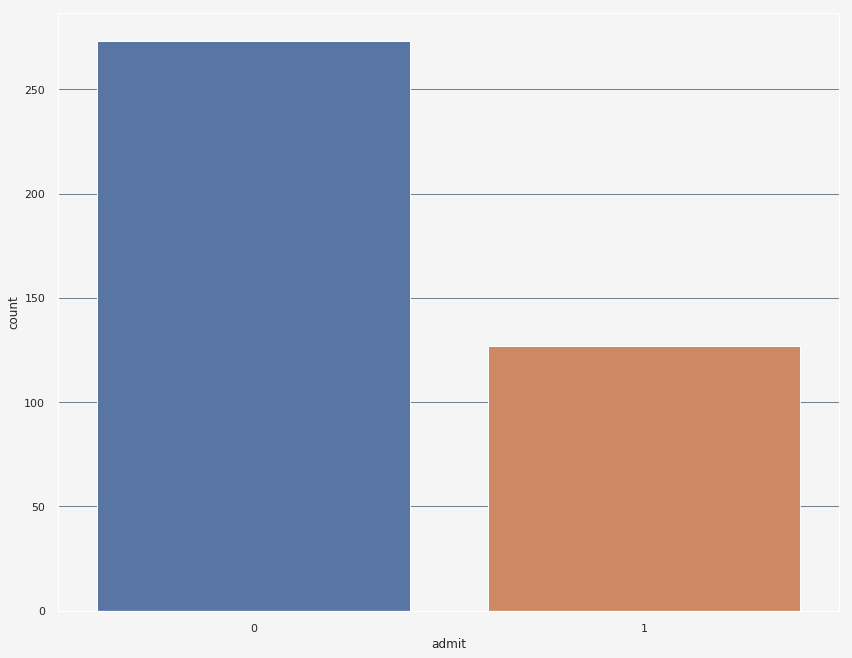

In [12]:
sns.countplot(x=uclastudent_dataset['admit'])

## Plotting the Data

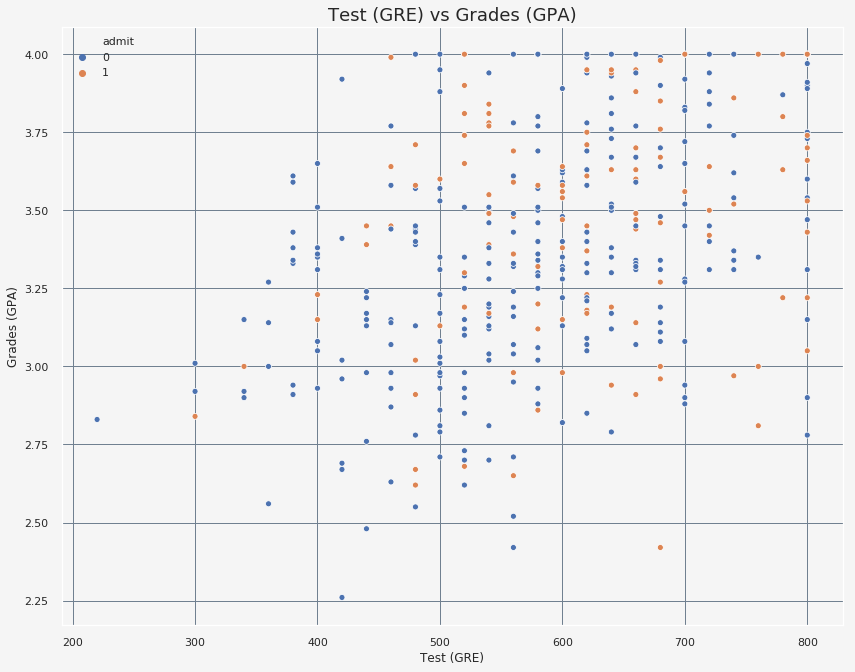

In [13]:
sns.scatterplot(x=uclastudent_dataset['gre'], y=uclastudent_dataset['gpa'], hue=uclastudent_dataset['admit'])
plt.xlabel('Test (GRE)')
plt.ylabel('Grades (GPA)')
plt.title('Test (GRE) vs Grades (GPA)', fontsize=18)
plt.show()

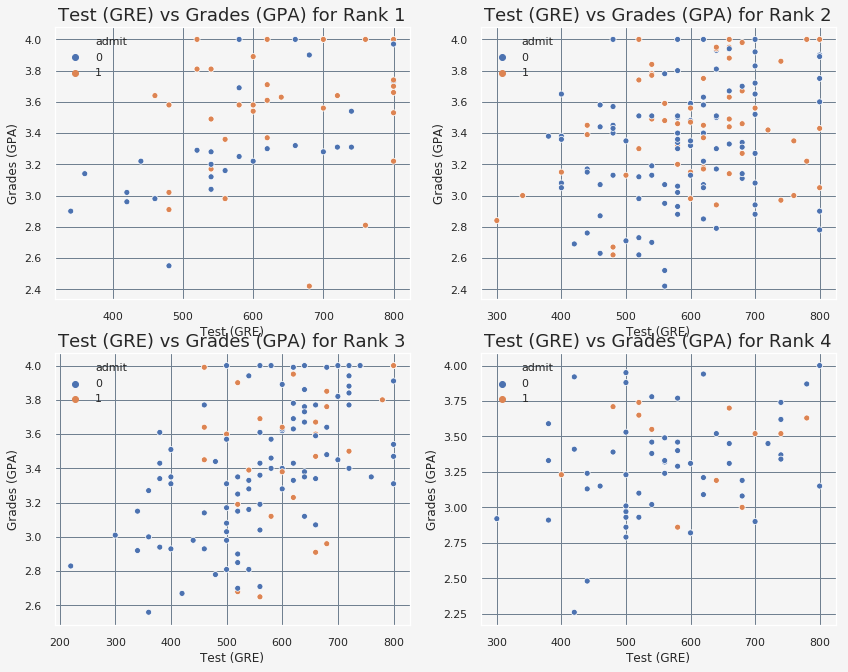

In [14]:
student_ranks = uclastudent_dataset['rank'].unique()

for i in student_ranks:
    data_by_rank = uclastudent_dataset[uclastudent_dataset['rank'] == i]
    plt.subplot(2, 2, i)
    sns.scatterplot(x=data_by_rank['gre'], y=data_by_rank['gpa'], hue=data_by_rank['admit'])
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    plt.title('Test (GRE) vs Grades (GPA) for Rank ' + str(i), fontsize=18)
plt.show()

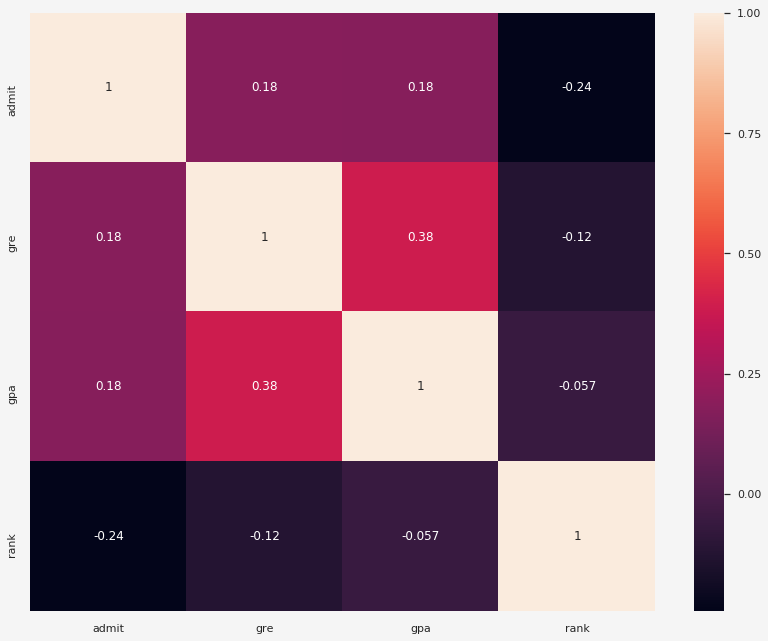

In [15]:
sns.heatmap(uclastudent_dataset.corr(), annot=True)

## One-Hot encoding and scaling the data

In [16]:
rank_dataset = pd.get_dummies(uclastudent_dataset['rank'], prefix='rank', drop_first=True)

uclastudent_dataset = pd.concat([uclastudent_dataset, rank_dataset], axis=1)
uclastudent_dataset.head()

,admit,gre,gpa,rank,rank_2,rank_3,rank_4
0,0,380,3.61,3,0,1,0
1,1,660,3.67,3,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,4,0,0,1
4,0,520,2.93,4,0,0,1


In [17]:
uclastudent_dataset.drop('rank', axis=1, inplace=True)
uclastudent_dataset.head()

,admit,gre,gpa,rank_2,rank_3,rank_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [18]:
uclastudent_dataset['gre'] = uclastudent_dataset['gre'] / 800.
uclastudent_dataset['gpa'] = uclastudent_dataset['gpa'] / 4.

uclastudent_dataset['admit'] = tf.keras.utils.to_categorical(uclastudent_dataset['admit'], num_classes=2)

uclastudent_dataset.head()

,admit,gre,gpa,rank_2,rank_3,rank_4
0,1.0,0.475,0.9025,0,1,0
1,0.0,0.825,0.9175,0,1,0
2,0.0,1.000,1.0000,0,0,0
3,0.0,0.800,0.7975,0,0,1
4,1.0,0.650,0.7325,0,0,1


## Splitting the data into features and targets (labels)

In [0]:
inputs = uclastudent_dataset.drop('admit', axis=1)
targets = uclastudent_dataset['admit']

## Splitting the data into Training and Testing

In [0]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

## Save data in NPZ format and read into the variables

In [0]:
# Save the three datasets in *.npz.
np.savez('audiobook_us_data_train.npz', inputs=X_train, targets=y_train)
np.savez('audiobook_us_data_test.npz', inputs=X_test, targets=y_test)

# Load all three datasets in temporary variables
train_dataset = np.load('audiobook_us_data_train.npz')
test_dataset = np.load('audiobook_us_data_test.npz')

train_inputs, train_targets = train_dataset['inputs'].astype(np.float), train_dataset['targets']
test_inputs, test_targets = test_dataset['inputs'].astype(np.float), test_dataset['targets']

## Training Neural Network

In [22]:
# Set the input and output sizes
input_size = 5
output_size = 2

# Set the batch size
batch_size = 100
# Set a maximum number of training epochs
max_epochs = 100

# Define the model
model = tf.keras.Sequential([tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.10),
                             tf.keras.layers.Dense(output_size, activation='softmax')
                            ])
# Choose the optimizer, the loss function and the metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(train_inputs,
          train_targets,
          batch_size=batch_size,
          epochs=max_epochs,
          verbose = 1
          )

Train on 320 samples
Epoch 1/100
320/320 [==============================] - 1s 4ms/sample - loss: 0.6937 - accuracy: 0.4969
Epoch 2/100
320/320 [==============================] - 0s 65us/sample - loss: 0.6487 - accuracy: 0.6594
Epoch 3/100
320/320 [==============================] - 0s 86us/sample - loss: 0.6403 - accuracy: 0.6687
Epoch 4/100
320/320 [==============================] - 0s 55us/sample - loss: 0.6314 - accuracy: 0.6687
Epoch 5/100
320/320 [==============================] - 0s 59us/sample - loss: 0.6271 - accuracy: 0.6687
Epoch 6/100
320/320 [==============================] - 0s 62us/sample - loss: 0.6256 - accuracy: 0.6687
Epoch 7/100
320/320 [==============================] - 0s 60us/sample - loss: 0.6310 - accuracy: 0.6687
Epoch 8/100
320/320 [==============================] - 0s 62us/sample - loss: 0.6221 - accuracy: 0.6687
Epoch 9/100
320/320 [==============================] - 0s 54us/sample - loss: 0.6117 - accuracy: 0.6687
Epoch 10/100
320/320 [======================

In [23]:
model.weights[5]

<tf.Variable 'sequential/dense_2/bias:0' shape=(2,) dtype=float32, numpy=array([-0.03742139,  0.03742139], dtype=float32)>

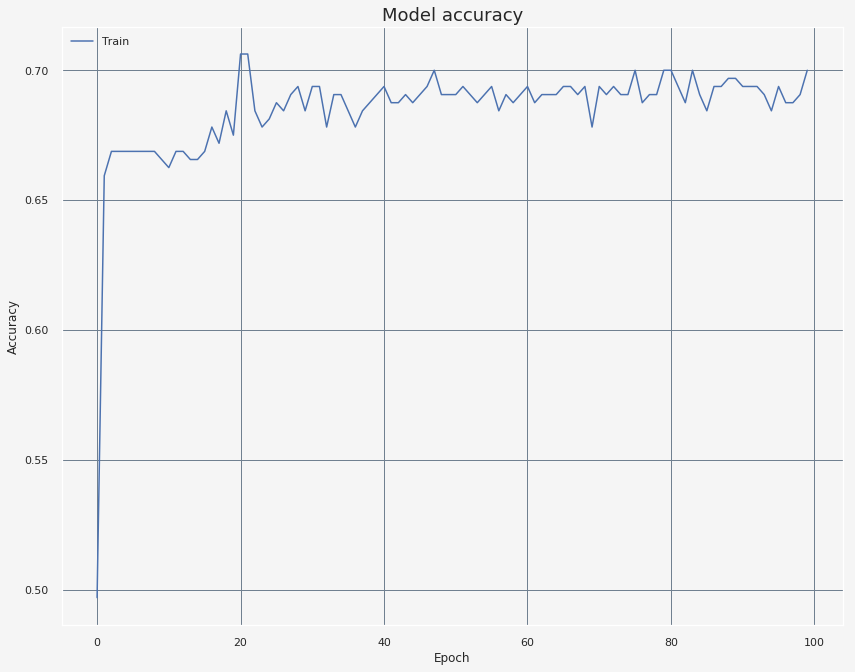

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

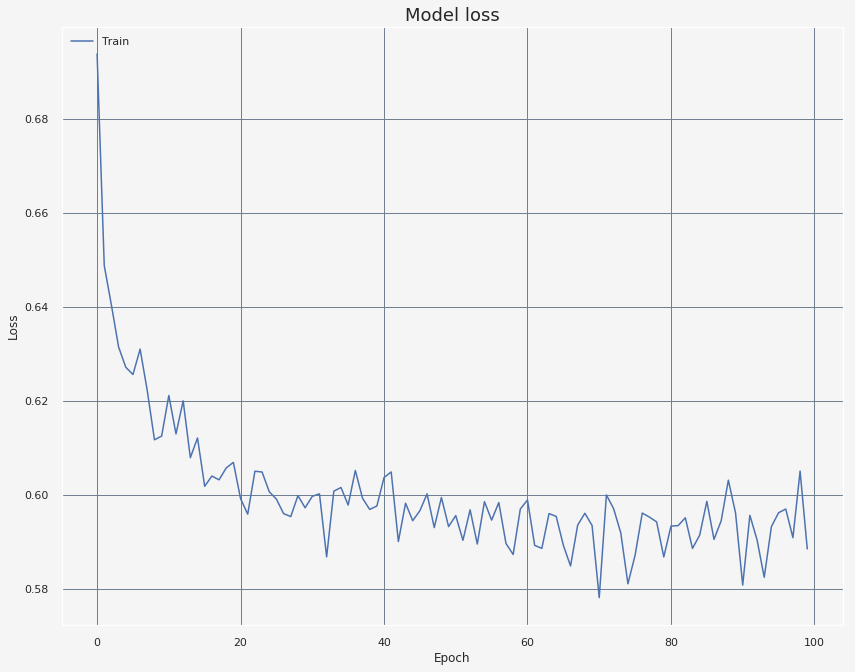

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss', fontsize=18)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculating the Accuracy on the Test Data

In [26]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

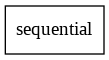

In [27]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)